In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
diet = pd.read_csv("/content/daily_food_nutrition_dataset.csv")
gym = pd.read_csv("/content/gym_members_exercise_tracking.csv")

In [34]:
diet = diet.drop_duplicates().fillna(diet.mean(numeric_only=True))
gym = gym.drop_duplicates().fillna(gym.mean(numeric_only=True))

In [35]:
gym["Age"] = pd.to_numeric(gym["Age"], errors="coerce")
gym = gym.dropna(subset=["Age"])

In [36]:
bins = [10, 20, 30, 40, 50, 60]
labels = ["15–19", "20–29", "30–39", "40–49", "50–55"]
gym["Age_Group"] = pd.cut(gym["Age"], bins=bins, labels=labels, right=False)


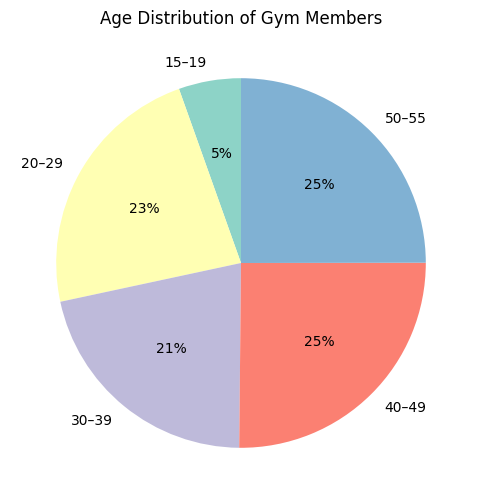

In [37]:
plt.figure(figsize=(6,6))
plt.pie(gym["Age_Group"].value_counts().sort_index(), labels=labels,
        autopct="%1.0f%%", startangle=90, colors=plt.cm.Set3.colors)
plt.title("Age Distribution of Gym Members")
plt.show()

In [38]:
gym["WeeklyExerciseMins"] = (
    gym["Session_Duration (hours)"] * gym["Workout_Frequency (days/week)"] * 60)


In [39]:
diet_dummies = pd.get_dummies(diet, drop_first=True)
gym_dummies = pd.get_dummies(gym, drop_first=True)
combined = pd.merge(gym_dummies, diet_dummies, on="User_ID", how="inner")

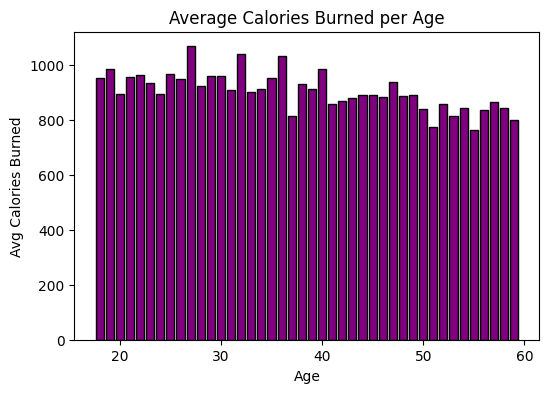

In [40]:
age_avg = combined.groupby("Age")["Calories_Burned"].mean()
plt.figure(figsize=(6,4))
plt.bar(age_avg.index, age_avg.values, color="purple", edgecolor="black")
plt.title("Average Calories Burned per Age")
plt.xlabel("Age")
plt.ylabel("Avg Calories Burned")
plt.show()


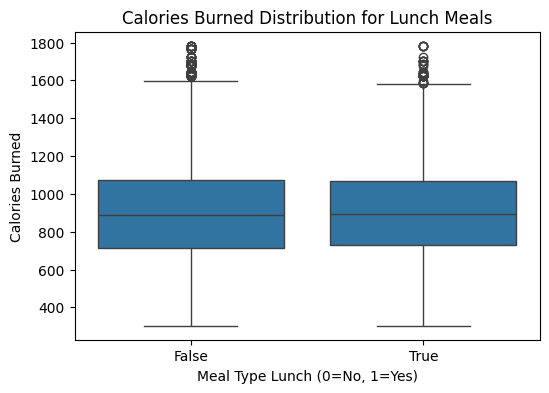

In [41]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Meal_Type_Lunch", y="Calories_Burned", data=combined)
plt.title("Calories Burned Distribution for Lunch Meals")
plt.xlabel("Meal Type Lunch (0=No, 1=Yes)")
plt.ylabel("Calories Burned")
plt.show()


In [42]:
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['<20', '21-30', '31-40', '41-50', '51-60', '60+']
combined['Age_Group'] = pd.cut(combined['Age'], bins=bins, labels=labels, right=False)

In [43]:
category_cols = [col for col in combined.columns if 'Category_' in col]
age_category_calories = combined.groupby('Age_Group')[category_cols].sum()

/tmp/ipython-input-3190474553.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_category_calories = combined.groupby('Age_Group')[category_cols].sum()


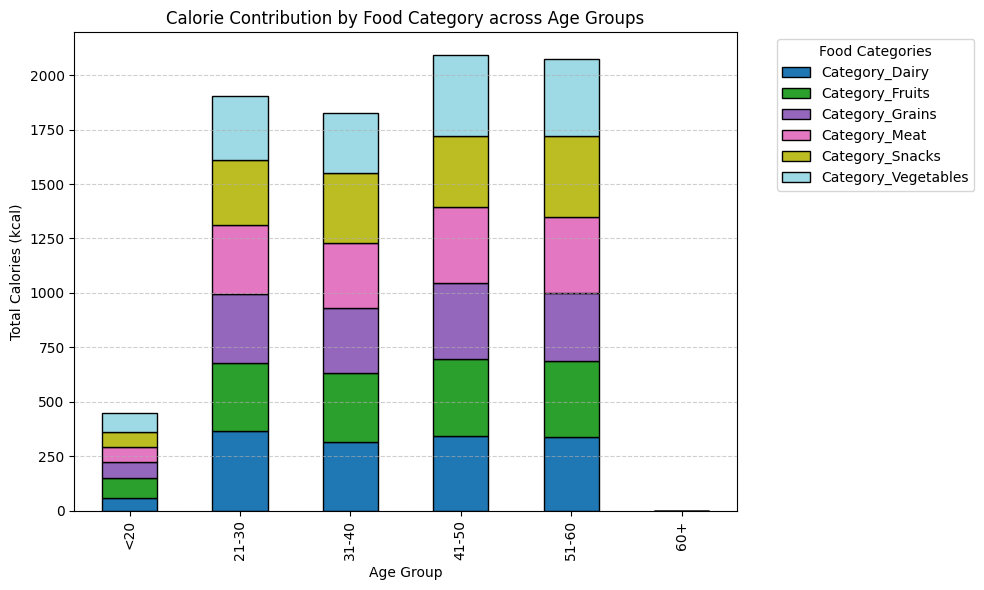

In [44]:
age_category_calories.plot(kind='bar', stacked=True, figsize=(10,6),
                           colormap='tab20', edgecolor='black')
plt.title("Calorie Contribution by Food Category across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Total Calories (kcal)")
plt.legend(title="Food Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [45]:
numeric_combined = combined.select_dtypes(include=['number'])
correlations = numeric_combined.corr()["WeeklyExerciseMins"].sort_values(ascending=False)
print(correlations.head())

WeeklyExerciseMins               1.000000
Workout_Frequency (days/week)    0.904005
Session_Duration (hours)         0.889978
Experience_Level                 0.889269
Calories_Burned                  0.801762
Name: WeeklyExerciseMins, dtype: float64


In [46]:
diet_sugar = diet.groupby("User_ID").agg(
    total_sugar=("Sugars (g)", "sum"),
    avg_sugar=("Sugars (g)", "mean")
).reset_index()


In [47]:
combined_sugar = pd.merge(diet_sugar, gym, on="User_ID", how="inner")
combined_sugar["Sugar_Level"] = pd.cut(
    combined_sugar["total_sugar"],
    bins=[0, 50, 100, 200, float("inf")],
    labels=["Low", "Medium", "High", "Very High"]
)

/tmp/ipython-input-1141578090.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_calories = combined_sugar.groupby("Sugar_Level")["Calories_Burned"].mean()


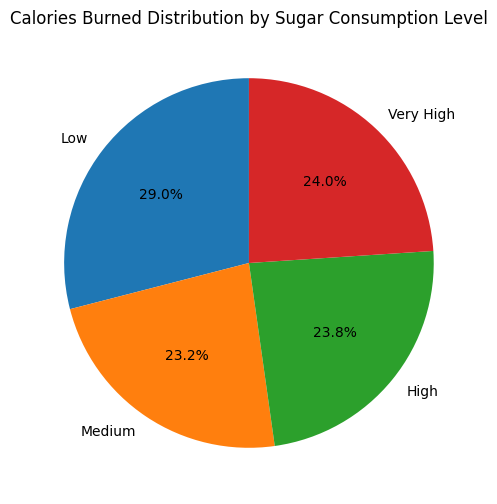

In [48]:
avg_calories = combined_sugar.groupby("Sugar_Level")["Calories_Burned"].mean()
plt.figure(figsize=(6,6))
plt.pie(avg_calories, labels=avg_calories.index, autopct="%1.1f%%", startangle=90)
plt.title("Calories Burned Distribution by Sugar Consumption Level")
plt.show()

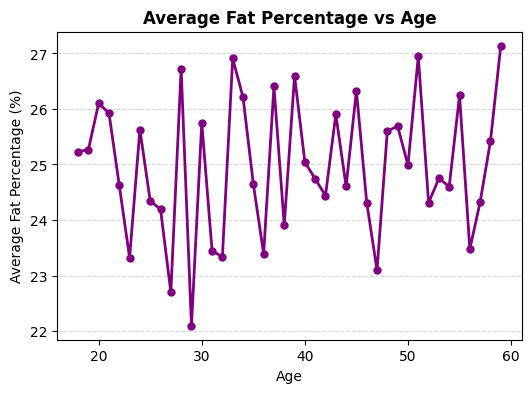

In [49]:
age_fat_avg = combined.groupby("Age")["Fat_Percentage"].mean().reset_index()

plt.figure(figsize=(6,4))
plt.plot(age_fat_avg["Age"], age_fat_avg["Fat_Percentage"],
         color="purple", marker="o", linewidth=2, markersize=5)

plt.title("Average Fat Percentage vs Age", fontsize=12, fontweight='bold')
plt.xlabel("Age")
plt.ylabel("Average Fat Percentage (%)")

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [50]:
grouped = combined.groupby("Calories (kcal)", as_index=False)["Calories_Burned"].mean()

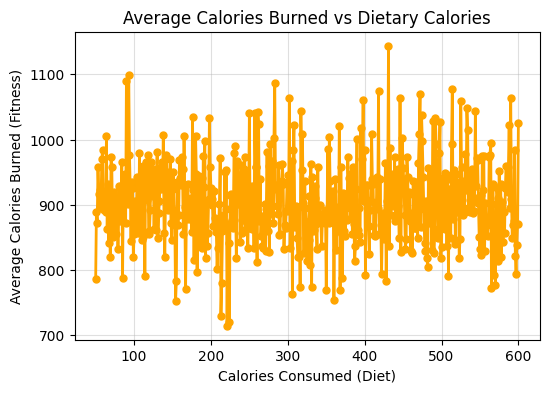

In [51]:
plt.figure(figsize=(6,4))
plt.plot(grouped["Calories (kcal)"], grouped["Calories_Burned"],
         color="orange", linewidth=2, marker="o", markersize=5)

plt.title("Average Calories Burned vs Dietary Calories")
plt.xlabel("Calories Consumed (Diet)")
plt.ylabel("Average Calories Burned (Fitness)")
plt.grid(alpha=0.4)
plt.show()

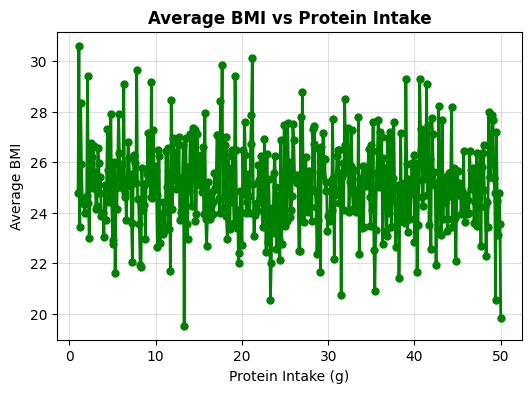

In [52]:
grouped = combined.groupby("Protein (g)", as_index=False)["BMI"].mean()
grouped = grouped.sort_values("Protein (g)")

plt.figure(figsize=(6,4))
plt.plot(grouped["Protein (g)"], grouped["BMI"],color="green", linewidth=2, marker="o", markersize=5)

plt.title("Average BMI vs Protein Intake", fontsize=12, fontweight='bold')
plt.xlabel("Protein Intake (g)")
plt.ylabel("Average BMI")
plt.grid(alpha=0.4)
plt.show()


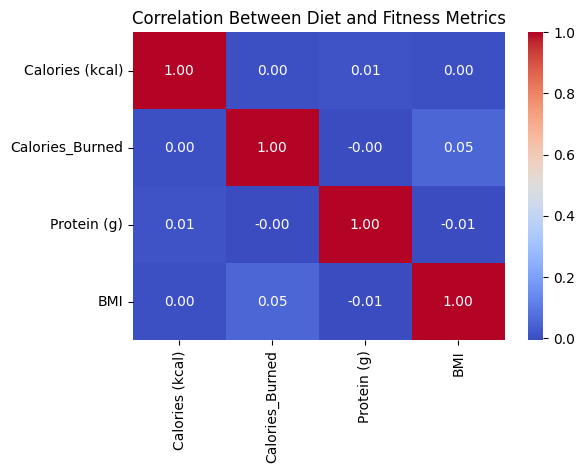

In [53]:
plt.figure(figsize=(6,4))
corr = combined[["Calories (kcal)", "Calories_Burned", "Protein (g)", "BMI"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Diet and Fitness Metrics")
plt.show()